In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from glob import glob 
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

In [26]:
Rice_Brown_Spot__images = glob("dataset/Wheat/Rice___Brown_Spot/*.jpg")
Rice_Healthy_images = glob("dataset/Wheat/Rice___Healthy/*.jpg")
Rice_Leaf_Blast_images = glob("dataset/Wheat/Rice___Leaf_Blast/*.jpg")
Rice_Neck_Blast_images = glob("dataset/Wheat/Rice___Neck_Blast/*.jpg")

In [27]:
print(f"Number of Rice_Brown_Spot_images: {len(Rice_Brown_Spot_images)}")
print(f"Number of Rice_Healthy_images: {len(Rice_Healthy_images)}")
print(f"Number of Rice_Leaf_Blast_images: {len(Rice_Leaf_Blast_images)}")
print(f"Number of Rice_Neck_Blast_images: {len(Rice_Neck_Blast_images)}")

Number of Rice_Brown_Spot_images: 902
Number of Rice_Healthy_images: 1116
Number of Rice_Leaf_Blast_images: 924


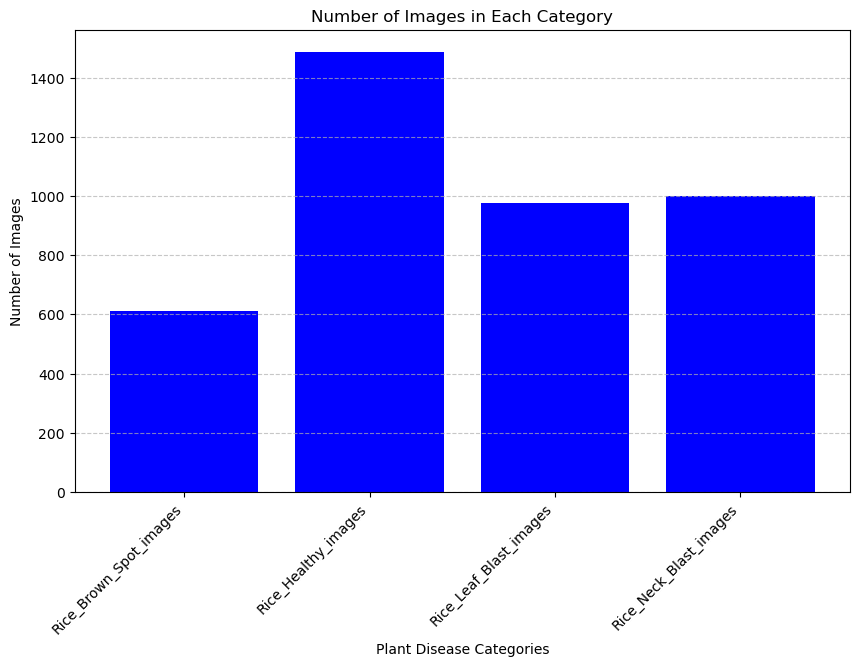

In [23]:
labels = ["Rice_Brown_Spot_images","Rice_Healthy_images","Rice_Leaf_Blast_images","Rice_Neck_Blast_images"]
counts = [len(Wheat_Brown_Rust_images),len(Wheat_Healthy_images),len(Wheat_Yellow_Rust_images),len(Rice_Neck_Blast_images)]

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='blue')

# Add labels and title
plt.xlabel("Plant Disease Categories")
plt.ylabel("Number of Images")
plt.title("Number of Images in Each Category")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [24]:
IMG_SIZE = (128, 128)

def load_images(folder):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder))  # Sorted for consistency
    label_map = {name: idx for idx, name in enumerate(class_names)}  # Label encoding

    for label in class_names:
        class_folder = os.path.join(folder, label)
        if os.path.isdir(class_folder):
            for file in glob(os.path.join(class_folder, "*.jpg")):  # Load only images
                img = cv2.imread(file)
                if img is None:
                    continue  # Skip unreadable images

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                img = cv2.resize(img, IMG_SIZE)  # Resize image
                img = img / 255.0  # Normalize pixels (0-1)
                
                images.append(img)
                labels.append(label_map[label])  # Store numerical label
    
    return np.array(images), np.array(labels), label_map  # Return label map for decoding


In [25]:
X, y, z = load_images('dataset/Corn')
print(f"Loaded {len(X)} images with {len(set(y))} classes.")

MemoryError: Unable to allocate 4.32 GiB for an array with shape (3852, 224, 224, 3) and data type float64

In [ ]:
print(z)

In [ ]:
# Define CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Helps prevent overfitting
    Dense(4, activation='softmax')  # 3 Output Neurons
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()

In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Normalize & split

train_generator = datagen.flow_from_directory(
    'dataset/Rice',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    'dataset/Rice',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# **Compute class weights from the directory**
class_counts = train_generator.class_indices  # Get class labels
class_samples = train_generator.samples  # Total training images

# Get label distribution
labels = list(class_counts.values())  # Numeric labels
class_weight_values = compute_class_weight(
    class_weight="balanced",
    classes=np.array(labels),
    y=np.repeat(labels, [class_samples])  # Fake labels for weight calculation
)

class_weights = {i: weight for i, weight in zip(labels, class_weight_values)}
print("Computed Class Weights:", class_weights)

# Train model using generator
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    # callbacks=[early_stopping],
     class_weight=class_weights
)


In [ ]:
train_generator.num_classes

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


In [ ]:
model.save("Rice_Disease.h5")